Band files found:
B04: E:\EO-SAR_change_detection\Data\RAW\Sentinel_2\post\S2B_MSIL1C_20251012T060709_N0511_R134_T41RRH_20251012T080323.SAFE\GRANULE\L1C_T41RRH_A044919_20251012T061323\IMG_DATA\T41RRH_20251012T060709_B04.jp2
B03: E:\EO-SAR_change_detection\Data\RAW\Sentinel_2\post\S2B_MSIL1C_20251012T060709_N0511_R134_T41RRH_20251012T080323.SAFE\GRANULE\L1C_T41RRH_A044919_20251012T061323\IMG_DATA\T41RRH_20251012T060709_B03.jp2
B02: E:\EO-SAR_change_detection\Data\RAW\Sentinel_2\post\S2B_MSIL1C_20251012T060709_N0511_R134_T41RRH_20251012T080323.SAFE\GRANULE\L1C_T41RRH_A044919_20251012T061323\IMG_DATA\T41RRH_20251012T060709_B02.jp2
B08: E:\EO-SAR_change_detection\Data\RAW\Sentinel_2\post\S2B_MSIL1C_20251012T060709_N0511_R134_T41RRH_20251012T080323.SAFE\GRANULE\L1C_T41RRH_A044919_20251012T061323\IMG_DATA\T41RRH_20251012T060709_B08.jp2
Georeferenced RGB+NIR raster saved at: E:\EO-SAR_change_detection\Data\Processed\Sentinel2\post\S2_merged_RGBNIR_post.tif


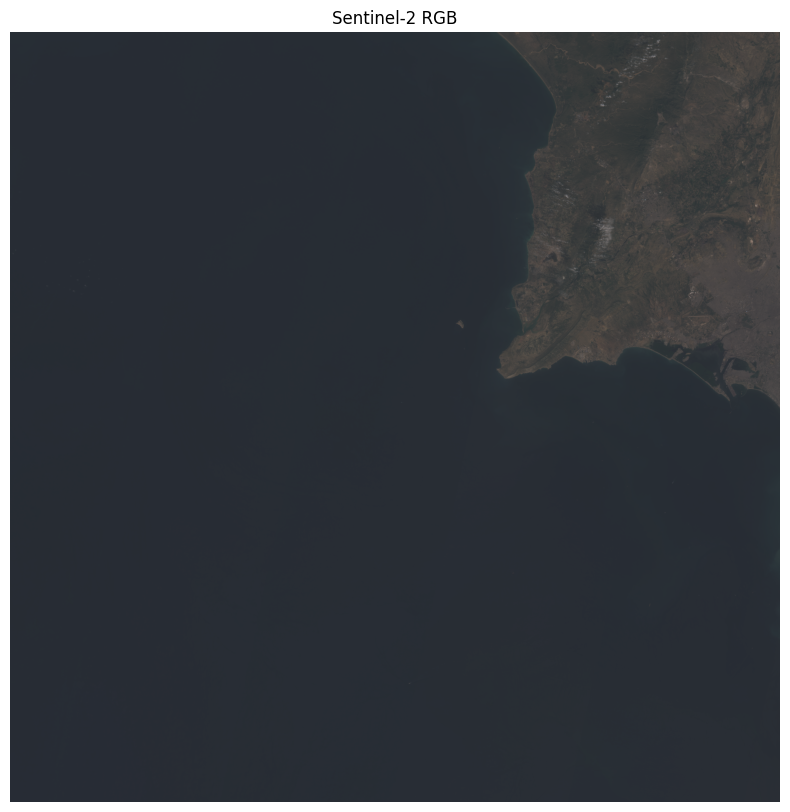

In [ ]:
import rasterio
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from rasterio.crs import CRS

# ===========================
# CONFIGURATION (Placeholders)
# ===========================
input_folder = r"PATH_TO_INPUT_SENTINEL2_FOLDER"
output_folder = r"PATH_TO_OUTPUT_PROCESSED_FOLDER"
bands = ["B04", "B03", "B02", "B08"]  # Red, Green, Blue, NIR
base_output_file = os.path.join(output_folder, "S2_merged_RGBNIR.tif")

# ===========================
# DEFINE CRS using proj4 string (EPSG:32641)
# ===========================
sentinel_crs = CRS.from_proj4("+proj=utm +zone=41 +datum=WGS84 +units=m +no_defs")

# ===========================
# CREATE OUTPUT FOLDER
# ===========================
os.makedirs(output_folder, exist_ok=True)

# ===========================
# SAFE FILE VERSIONING
# ===========================
counter = 1
output_file = base_output_file
while os.path.exists(output_file):
    output_file = os.path.join(output_folder, f"S2_merged_RGBNIR_v{counter}.tif")
    counter += 1

# ===========================
# FIND BAND FILES
# ===========================
band_files = {}
for band in bands:
    search_pattern = os.path.join(input_folder, "**", f"*{band}*.tif")
    files = glob(search_pattern, recursive=True)

    if not files:
        search_pattern = os.path.join(input_folder, "**", f"*{band}*.jp2")
        files = glob(search_pattern, recursive=True)

    if files:
        band_files[band] = files[0]
    else:
        raise FileNotFoundError(f"Band {band} not found in {input_folder}")

print("Band files found:")
for b, f in band_files.items():
    print(f"{b}: {f}")

# ===========================
# READ BANDS AND ENSURE ALIGNMENT
# ===========================
arrays = []
ref_meta = None

for i, band in enumerate(bands):
    with rasterio.open(band_files[band]) as src:
        data = src.read(1)

        if i == 0:
            ref_meta = src.meta.copy()
            ref_meta.update(
                count=len(bands),
                dtype=rasterio.uint16,
                crs=sentinel_crs
            )
        else:
            if src.width != ref_meta["width"] or src.height != ref_meta["height"]:
                raise ValueError(f"Band {band} shape mismatch")
            if src.transform != ref_meta["transform"]:
                raise ValueError(f"Band {band} transform mismatch")

        arrays.append(data)

stacked = np.stack(arrays, axis=0)

# ===========================
# SAVE MERGED GEOTIFF
# ===========================
with rasterio.open(output_file, "w", **ref_meta) as dst:
    dst.write(stacked)

print(f"Georeferenced RGB+NIR raster saved at: {output_file}")

# ===========================
# DISPLAY RGB QUICKLOOK
# ===========================
rgb = stacked[:3]
rgb = np.clip(rgb, 0, 10000)
rgb = ((rgb / 10000) * 255).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(rgb, (1, 2, 0)))
plt.axis("off")
plt.title("Sentinel-2 RGB")
plt.show()